## Notebook for the annotation transferring from 3 donors Gut Cell Atlas to Khaliq 2022 data
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 27 November 2022

#### Load required packages

In [1]:
import scnym

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an

#### Setup Cells

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi = 160, color_map = 'magma_r', dpi_save = 300, vector_friendly = True)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.22.2.post1 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.7.0 leidenalg==0.8.0


#### Read reference object

In [5]:
input_Normal_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Raw_data/Normal Control Gut Cell Atlas/Full_obj_raw_counts_nosoupx_v2.h5ad'  # the file that will store the analysis results
output_Normal_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Gut_cell_atlas_three_donors_output.h5ad'  # the file that will store the analysis results

In [6]:
#Anndata upload
control_ad = sc.read_h5ad(input_Normal_file)
control_ad.X

<428469x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 760344941 stored elements in Compressed Sparse Row format>

#### Quick Filtering of Gut Cell Atlas file

In [7]:
#Remove Pediatric Crohn Disease
control_ad_clean = control_ad[~control_ad.obs['Diagnosis'].isin(['Pediatric Crohn Disease']),:]
del control_ad
#Deleting the lymph node samples
control_ad_clean = control_ad_clean[~control_ad_clean.obs['Region'].isin(['lymph node']),:]
#Adding percentage of ribosomial genes
control_ad_clean.var['ribo'] = control_ad_clean.var_names.str.startswith(("RPS","RPL"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(control_ad_clean, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
#Filtering by genes
control_ad_clean = control_ad_clean[control_ad_clean.obs.n_genes_by_counts < 5000, :]
control_ad_clean = control_ad_clean[control_ad_clean.obs.n_genes_by_counts > 200, :]
#Filtering by counts
control_ad_clean = control_ad_clean[control_ad_clean.obs.total_counts < 50000, :]
# Chose three adult donors for further analysis
three_donors = control_ad_clean[control_ad_clean.obs['Sample name'].isin(['A33 (414C)', 'A34 (417C)', 'A32 (411C)']), :]
del control_ad_clean

Trying to set attribute `.var` of view, copying.


#### Read in query

In [10]:
input_CRC_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Raw_data/Khaliq-2022/Anndata raw/Khaliq-2022_anndata_raw_2_for_scnym.h5ad'  # the file that will store the analysis results
output_CRC_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Raw_data/Khaliq-2022/Anndata raw/Khaliq-2022_anndata_raw_2_for_scnym_output.h5ad'  # the file that will store the analysis results

In [11]:
#Anndata upload
Khaliq_ad = sc.read_h5ad(input_CRC_file)
Khaliq_ad.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Quick Filtering of query file

In [12]:
#Adding percentage of mitochondrial genes
Khaliq_ad.var['mt'] = Khaliq_ad.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(Khaliq_ad, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#Adding percentage of ribosomial genes
Khaliq_ad.var['ribo'] = Khaliq_ad.var_names.str.startswith(("RPS","RPL"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(Khaliq_ad, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
#Delete normal samples (leave only tumor)
Khaliq_ad = Khaliq_ad[Khaliq_ad.obs.Condition == "Tumor", :]

#### Format reference for `scNym`

In [13]:
three_donors

View of AnnData object with n_obs × n_vars = 83388 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
three_donors.obs['sample name'].cat.categories


Index(['A32-APD-0-SC-45N-1', 'A32-APD-0-SC-45P-1', 'A32-CAE-0-SC-45N-1',
       'A32-CAE-0-SC-45P-1', 'A32-ILE-1-SC-45N-1', 'A32-ILE-1-SC-45P-1',
       'A32-ILE-2-SC-45N-1', 'A32-ILE-2-SC-45P-1', 'A32-SCL-0-SC-45N-1',
       'A32-SCL-0-SC-45P-1', 'A32-TCL-0-SC-45N-1', 'A32-TCL-0-SC-45P-1',
       'A33-ACL-0-SC-45P-1', 'A33-APD-0-SC-45P-1', 'A33-CAE-0-SC-45N-1',
       'A33-CAE-0-SC-45P-1', 'A33-ILE-1-SC-45P-1', 'A33-ILE-2-SC-45P-1',
       'A33-JEJ-0-SC-45P-1', 'A33-REC-0-SC-45N-1', 'A33-REC-0-SC-45P-1 ',
       'A33-SCL-0-SC-45N-1', 'A33-TCL-0-SC-45N-1', 'A33-TCL-0-SC-45P-1',
       'A34-ACL-1-SC-45N-1', 'A34-ACL-1-SC-45P-1', 'A34-APD-1-SC-45N-1',
       'A34-APD-1-SC-45P-1', 'A34-CAE-1-SC-45N-1', 'A34-CAE-1-SC-45P-1',
       'A34-DCL-1-SC-45N-1', 'A34-DCL-1-SC-45P-1', 'A34-DUO-1-SC-45N-1',
       'A34-DUO-2-SC-45N-1', 'A34-DUO-2-SC-45P-1', 'A34-ILE-1-SC-45N-1',
       'A34-ILE-1-SC-45P-1', 'A34-ILE-2-SC-45N-1', 'A34-ILE-2-SC-45P-1',
       'A34-JEJ-1-SC-45N-1', 'A34-JEJ-1-SC-45P-1',

In [14]:
Khaliq_ad

View of AnnData object with n_obs × n_vars = 31586 × 23828
    obs: 'samples', 'Condition', 'Location', 'MSI_Status', 'bulk_prediction', 'prediction', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [20]:
Khaliq_ad.obs['samples'].cat.categories

Index(['T_cac1', 'T_cac2', 'T_cac3', 'T_cac4', 'T_cac5', 'T_cac6', 'T_cac7',
       'T_cac8', 'T_cac9', 'T_cac10', 'T_cac11', 'T_cac12', 'T_cac13',
       'T_cac14', 'T_cac15', 'T_cac16'],
      dtype='object')

In [21]:
Khaliq_ad.obs["Study"] = "Khaliq, 2022"
Khaliq_ad.obs['Study'] = Khaliq_ad.obs['Study'].astype('category')
three_donors.obs["Study"] = "Gut Cell Atlas"
three_donors.obs['Study'] = three_donors.obs['Study'].astype('category')
Khaliq_ad.obs.rename(columns={"samples": "sample name"}, inplace=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [22]:
Khaliq_ad.obs['domain_label'] = Khaliq_ad.obs['sample name'].copy()
Khaliq_ad.obs['domain_label'] = 'target_' + Khaliq_ad.obs['domain_label'].astype(str)
Khaliq_ad.obs['domain_label'] = Khaliq_ad.obs['domain_label'].astype('category')
Khaliq_ad.obs['domain_label'].cat.categories

Index(['target_T_cac1', 'target_T_cac10', 'target_T_cac11', 'target_T_cac12',
       'target_T_cac13', 'target_T_cac14', 'target_T_cac15', 'target_T_cac16',
       'target_T_cac2', 'target_T_cac3', 'target_T_cac4', 'target_T_cac5',
       'target_T_cac6', 'target_T_cac7', 'target_T_cac8', 'target_T_cac9'],
      dtype='object')

In [23]:
Khaliq_ad.obs['cell_states'] = 'Unlabeled'
Khaliq_ad.obs['cell_states'] = Khaliq_ad.obs['cell_states'].astype('category')

In [24]:
Khaliq_ad.obs

sample name Condition Location MSI_Status  \
T_cac1_AAACCTGAGAATAGGG      T_cac1     Tumor    Right        MSS   
T_cac1_AAACCTGAGCAGCGTA      T_cac1     Tumor    Right        MSS   
T_cac1_AAACCTGCAATCTGCA      T_cac1     Tumor    Right        MSS   
T_cac1_AAACCTGGTCTTGCGG      T_cac1     Tumor    Right        MSS   
T_cac1_AAACCTGGTGTGCCTG      T_cac1     Tumor    Right        MSS   
...                             ...       ...      ...        ...   
T_cac9_TTTGGTTCAACACGCC      T_cac9     Tumor     Left        MSS   
T_cac9_TTTGGTTCATAGACTC      T_cac9     Tumor     Left        MSS   
T_cac9_TTTGGTTCATCTATGG      T_cac9     Tumor     Left        MSS   
T_cac9_TTTGGTTTCAATCTCT      T_cac9     Tumor     Left        MSS   
T_cac9_TTTGTCAGTCCAACTA      T_cac9     Tumor     Left        MSS   

                        bulk_prediction prediction  n_genes_by_counts  \
T_cac1_AAACCTGAGAATAGGG            CMS4       CMS2                504   
T_cac1_AAACCTGAGCAGCGTA            CMS4       CMS4               3177   
T_cac1_AAACCTGCAATCTGCA            CMS4       CMS3                465   
T_cac1_AAACCTGGTCTTGCGG            CMS4       CMS3                329   
T_cac1_AAACCTGGTGTGCCTG            CMS4       CMS3               2887   
...                                 ...        ...                ...   
T_cac9_TTTGGTTCAACACGCC            CMS2       CMS4               1355   
T_cac9_TTTGGTTCATAGACTC            CMS2       CMS4               2220   
T_cac9_TTTGGTTCATCTATGG            CMS2       CMS1               1303   
T_cac9_TTTGGTTTCAATCTCT            CMS2       CMS1                595   
T_cac9_TTTGTCAGTCCAACTA            CMS2       CMS1               1130   

                         total_counts  total_counts_mt  pct_counts_mt  \
T_cac1_AAACCTGAGAATAGGG         922.0            142.0      15.401300   
T_cac1_AAACCTGAGCAGCGTA       11519.0            526.0       4.566369   
T_cac1_AAACCTGCAATCTGCA         831.0            166.0      19.975931   
T_cac1_AAACCTGGTCTTGCGG         527.0             32.0       6.072106   
T_cac1_AAACCTGGTGTGCCTG        8388.0            820.0       9.775870   
...                               ...              ...            ...   
T_cac9_TTTGGTTCAACACGCC        3463.0            147.0       4.244874   
T_cac9_TTTGGTTCATAGACTC        7173.0            286.0       3.987174   
T_cac9_TTTGGTTCATCTATGG        3283.0            263.0       8.010965   
T_cac9_TTTGGTTTCAATCTCT         995.0            107.0      10.753769   
T_cac9_TTTGTCAGTCCAACTA        3251.0             96.0       2.952938   

                         total_counts_ribo  pct_counts_ribo         Study  \
T_cac1_AAACCTGAGAATAGGG              133.0        14.425163  Khaliq, 2022   
T_cac1_AAACCTGAGCAGCGTA             1656.0        14.376248  Khaliq, 2022   
T_cac1_AAACCTGCAATCTGCA               50.0         6.016847  Khaliq, 2022   
T_cac1_AAACCTGGTCTTGCGG               99.0        18.785578  Khaliq, 2022   
T_cac1_AAACCTGGTGTGCCTG             1501.0        17.894611  Khaliq, 2022   
...                                    ...              ...           ...   
T_cac9_TTTGGTTCAACACGCC              853.0        24.631823  Khaliq, 2022   
T_cac9_TTTGGTTCATAGACTC             1994.0        27.798689  Khaliq, 2022   
T_cac9_TTTGGTTCATCTATGG              771.0        23.484617  Khaliq, 2022   
T_cac9_TTTGGTTTCAATCTCT               33.0         3.316583  Khaliq, 2022   
T_cac9_TTTGTCAGTCCAACTA              794.0        24.423256  Khaliq, 2022   

                          domain_label cell_states  
T_cac1_AAACCTGAGAATAGGG  target_T_cac1   Unlabeled  
T_cac1_AAACCTGAGCAGCGTA  target_T_cac1   Unlabeled  
T_cac1_AAACCTGCAATCTGCA  target_T_cac1   Unlabeled  
T_cac1_AAACCTGGTCTTGCGG  target_T_cac1   Unlabeled  
T_cac1_AAACCTGGTGTGCCTG  target_T_cac1   Unlabeled  
...                                ...         ...  
T_cac9_TTTGGTTCAACACGCC  target_T_cac9   Unlabeled  
T_cac9_TTTGGTTCATAGACTC  target_T_cac9   Unlabeled  
T_cac9_TTTGGTTCATCTATGG  target_T_cac9 

#### Format reference for `scNym`

In [25]:
three_donors.obs['cell_states'] = three_donors.obs['category'].copy()
three_donors.obs['cell_states'] = three_donors.obs['cell_states'].astype('category')

In [26]:
three_donors.obs['domain_label'] = three_donors.obs['sample name'].copy()
three_donors.obs['domain_label'] = 'train_' + three_donors.obs['domain_label'].astype(str)
three_donors.obs['domain_label'] = three_donors.obs['domain_label'].astype('category')
three_donors.obs['domain_label'].cat.categories

Index(['train_A32-APD-0-SC-45N-1', 'train_A32-APD-0-SC-45P-1',
       'train_A32-CAE-0-SC-45N-1', 'train_A32-CAE-0-SC-45P-1',
       'train_A32-ILE-1-SC-45N-1', 'train_A32-ILE-1-SC-45P-1',
       'train_A32-ILE-2-SC-45N-1', 'train_A32-ILE-2-SC-45P-1',
       'train_A32-SCL-0-SC-45N-1', 'train_A32-SCL-0-SC-45P-1',
       'train_A32-TCL-0-SC-45N-1', 'train_A32-TCL-0-SC-45P-1',
       'train_A33-ACL-0-SC-45P-1', 'train_A33-APD-0-SC-45P-1',
       'train_A33-CAE-0-SC-45N-1', 'train_A33-CAE-0-SC-45P-1',
       'train_A33-ILE-1-SC-45P-1', 'train_A33-ILE-2-SC-45P-1',
       'train_A33-JEJ-0-SC-45P-1', 'train_A33-REC-0-SC-45N-1',
       'train_A33-REC-0-SC-45P-1 ', 'train_A33-SCL-0-SC-45N-1',
       'train_A33-TCL-0-SC-45N-1', 'train_A33-TCL-0-SC-45P-1',
       'train_A34-ACL-1-SC-45N-1', 'train_A34-ACL-1-SC-45P-1',
       'train_A34-APD-1-SC-45N-1', 'train_A34-APD-1-SC-45P-1',
       'train_A34-CAE-1-SC-45N-1', 'train_A34-CAE-1-SC-45P-1',
       'train_A34-DCL-1-SC-45N-1', 'train_A34-DCL-1-SC

#### Merge two objects 

In [29]:
REF_QUERY = Khaliq_ad.concatenate(three_donors, batch_key = 'object', batch_categories = ['query', 'reference'], join = 'inner')
REF_QUERY

AnnData object with n_obs × n_vars = 114974 × 23811
    obs: 'sample name', 'Condition', 'Location', 'MSI_Status', 'bulk_prediction', 'prediction', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Study', 'domain_label', 'cell_states', 'Sample name', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'object'
    var: 'ribo', 'mt-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'n_cells_by_counts-reference', 'mean_counts-reference', 'pct_dropout_by_counts-reference', 'total_counts-reference', 'gene_ids-reference', 'feature_types-reference'

In [30]:
REF_QUERY.obs

sample name Condition  \
T_cac1_AAACCTGAGAATAGGG-query                             T_cac1     Tumor   
T_cac1_AAACCTGAGCAGCGTA-query                             T_cac1     Tumor   
T_cac1_AAACCTGCAATCTGCA-query                             T_cac1     Tumor   
T_cac1_AAACCTGGTCTTGCGG-query                             T_cac1     Tumor   
T_cac1_AAACCTGGTGTGCCTG-query                             T_cac1     Tumor   
...                                                          ...       ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1       NaN   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1       NaN   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1       NaN   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1       NaN   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1       NaN   

                                             Location MSI_Status  \
T_cac1_AAACCTGAGAATAGGG-query                   Right        MSS   
T_cac1_AAACCTGAGCAGCGTA-query                   Right        MSS   
T_cac1_AAACCTGCAATCTGCA-query                   Right        MSS   
T_cac1_AAACCTGGTCTTGCGG-query                   Right        MSS   
T_cac1_AAACCTGGTGTGCCTG-query                   Right        MSS   
...                                               ...        ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference      NaN        NaN   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference      NaN        NaN   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference      NaN        NaN   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference      NaN        NaN   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference      NaN        NaN   

                                             bulk_prediction prediction  \
T_cac1_AAACCTGAGAATAGGG-query                           CMS4       CMS2   
T_cac1_AAACCTGAGCAGCGTA-query                           CMS4       CMS4   
T_cac1_AAACCTGCAATCTGCA-query                           CMS4       CMS3   
T_cac1_AAACCTGGTCTTGCGG-query                           CMS4       CMS3   
T_cac1_AAACCTGGTGTGCCTG-query                           CMS4       CMS3   
...                                                      ...        ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference             NaN        NaN   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference             NaN        NaN   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference             NaN        NaN   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference             NaN        NaN   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference             NaN        NaN   

                                              n_genes_by_counts  total_counts  \
T_cac1_AAACCTGAGAATAGGG-query                               504         922.0   
T_cac1_AAACCTGAGCAGCGTA-query                              3177       11519.0   
T_cac1_AAACCTGCAATCTGCA-query                               465         831.0   
T_cac1_AAACCTGGTCTTGCGG-query                               329         527.0   
T_cac1_AAACCTGGTGTGCCTG-query                              2887        8388.0   
...                                                         ...           ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference               1016        2057.0   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference                582        1001.0   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference                640        1119.0   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference               1945        4808.0   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference                550         828.0   

                                              total_counts_mt  pct_counts_mt  \
T_cac1_AAACCTGAGAATAGGG-query                      142.000000      15.401300   
T_cac1_AAACCTGAGCAGCGTA-query                      526.000000       4.566369   
T_cac1_AAACCTGCAATCTGCA-query                      166.000000      19.975931   
T_cac1_AAACCTGGTCTTGCGG-query                       32.000000       6.072106   
T_cac1_AAACCTGGTGTGCCTG-q

#### Clean up object

- Clean up `adata.obs`

In [31]:
REF_QUERY.obs.drop(REF_QUERY.obs.columns.difference(['sample name', 'domain_label','cell_states', 'object']), 1, inplace = True)
REF_QUERY

AnnData object with n_obs × n_vars = 114974 × 23811
    obs: 'sample name', 'domain_label', 'cell_states', 'object'
    var: 'ribo', 'mt-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'n_cells_by_counts-reference', 'mean_counts-reference', 'pct_dropout_by_counts-reference', 'total_counts-reference', 'gene_ids-reference', 'feature_types-reference'

- Clean up `adata.var`

In [35]:
REF_QUERY.var.drop(REF_QUERY.var.columns.difference(['mt']), 1, inplace = True)
REF_QUERY

AnnData object with n_obs × n_vars = 114974 × 23811
    obs: 'sample name', 'domain_label', 'cell_states', 'object'

In [36]:
del Khaliq_ad, three_donors

#### LogP1 normalization

In [37]:
#Log normalization
sc.pp.log1p(REF_QUERY)

In [39]:
REF_QUERY.obs


sample name  \
T_cac1_AAACCTGAGAATAGGG-query                             T_cac1   
T_cac1_AAACCTGAGCAGCGTA-query                             T_cac1   
T_cac1_AAACCTGCAATCTGCA-query                             T_cac1   
T_cac1_AAACCTGGTCTTGCGG-query                             T_cac1   
T_cac1_AAACCTGGTGTGCCTG-query                             T_cac1   
...                                                          ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference  A33-ILE-1-SC-45P-1   

                                                          domain_label  \
T_cac1_AAACCTGAGAATAGGG-query                            target_T_cac1   
T_cac1_AAACCTGAGCAGCGTA-query                            target_T_cac1   
T_cac1_AAACCTGCAATCTGCA-query                            target_T_cac1   
T_cac1_AAACCTGGTCTTGCGG-query                            target_T_cac1   
T_cac1_AAACCTGGTGTGCCTG-query                            target_T_cac1   
...                                                                ...   
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference  train_A33-ILE-1-SC-45P-1   
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference  train_A33-ILE-1-SC-45P-1   
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference  train_A33-ILE-1-SC-45P-1   
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference  train_A33-ILE-1-SC-45P-1   
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference  train_A33-ILE-1-SC-45P-1   

                                              cell_states     object  
T_cac1_AAACCTGAGAATAGGG-query                   Unlabeled      query  
T_cac1_AAACCTGAGCAGCGTA-query                   Unlabeled      query  
T_cac1_AAACCTGCAATCTGCA-query                   Unlabeled      query  
T_cac1_AAACCTGGTCTTGCGG-query                   Unlabeled      query  
T_cac1_AAACCTGGTGTGCCTG-query                   Unlabeled      query  
...                                                   ...        ...  
TTTATGCTCTTCCTTC-1-WTDAtest7844019-reference   Epithelial  reference  
TTTCCTCTCTCGTTTA-1-WTDAtest7844019-reference  Endothelial  reference  
TTTGCGCCACACCGAC-1-WTDAtest7844019-reference   Epithelial  reference  
TTTGCGCTCCCTGACT-1-WTDAtest7844019-reference  Endothelial  reference  
TTTGGTTTCTTGCCGT-1-WTDAtest7844019-reference   Epithelial  reference  

[114974 rows x 4 columns]

#### Train reference with `scNym`

In [40]:
scnym.api.scnym_api(
    adata = REF_QUERY,
    task = 'train',
    groupby = 'cell_states',
    domain_groupby='domain_label',
    out_path = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/',
    config = 'new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

31586 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (83388, 23811)
target   examples:  (31586, 23811)
X:  (83388, 23811)
y:  (83388,)
Using user provided domain labels.
Found 47 source domains and 16 target domains.
Not weighting classes and not balancing classes.
Found 63 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `

In [41]:
scnym.api.scnym_api(
    adata=REF_QUERY,
    task='predict',
    key_added='scNym',
    trained_model='./scnym_output',
    out_path='./scnym_output',
    config='new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 8 classes from 33264 features
['B cells' 'Endothelial' 'Epithelial' 'Mesenchymal' 'Myeloid' 'Neuronal'
 'Plasma cells' 'T cells']
Building a classification matrix...


mapping genes: 23811it [00:12, 1948.44it/s]
copying gene batches: 100%|█████████████████████| 65/65 [02:26<00:00,  2.25s/it]


Found 23570 common genes.
Predicting cell types...


Finding cell types: 100%|█████████████████████| 113/113 [00:31<00:00,  3.57it/s]


Extracting model embeddings...


In [42]:
REF_QUERY.obs['scNym'].value_counts()

Epithelial      104673
Plasma cells     10301
Name: scNym, dtype: int64

#### Save the object

In [43]:
adata_export = an.AnnData(X = REF_QUERY.X, obs = REF_QUERY.obs, var = REF_QUERY.var, uns = REF_QUERY.uns, obsm = REF_QUERY.obsm, obsp = REF_QUERY.obsp)
adata_export

AnnData object with n_obs × n_vars = 114974 × 23811
    obs: 'sample name', 'domain_label', 'cell_states', 'object', 'scNym', 'scNym_confidence'
    uns: 'log1p', 'scNym_train_results', 'scNym_probabilities'
    obsm: 'X_scnym'

In [44]:
adata_export.write('/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Post_scnym_Khaliq_three_donors_trained.h5ad')

... storing 'sample name' as categorical
... storing 'domain_label' as categorical
... storing 'cell_states' as categorical
... storing 'scNym' as categorical


#### UMAPs

In [45]:
sc.pp.neighbors(REF_QUERY, use_rep = 'X_scnym', n_neighbors = 50)
sc.tl.umap(REF_QUERY, min_dist = 0.2, spread = 5, random_state = 1712)

computing neighbors


/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/numba/core/typed_passes.py:313: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:30)
computing UMAP


/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:28)


... storing 'sample name' as categorical
... storing 'domain_label' as categorical
... storing 'cell_states' as categorical
... storing 'scNym' as categorical


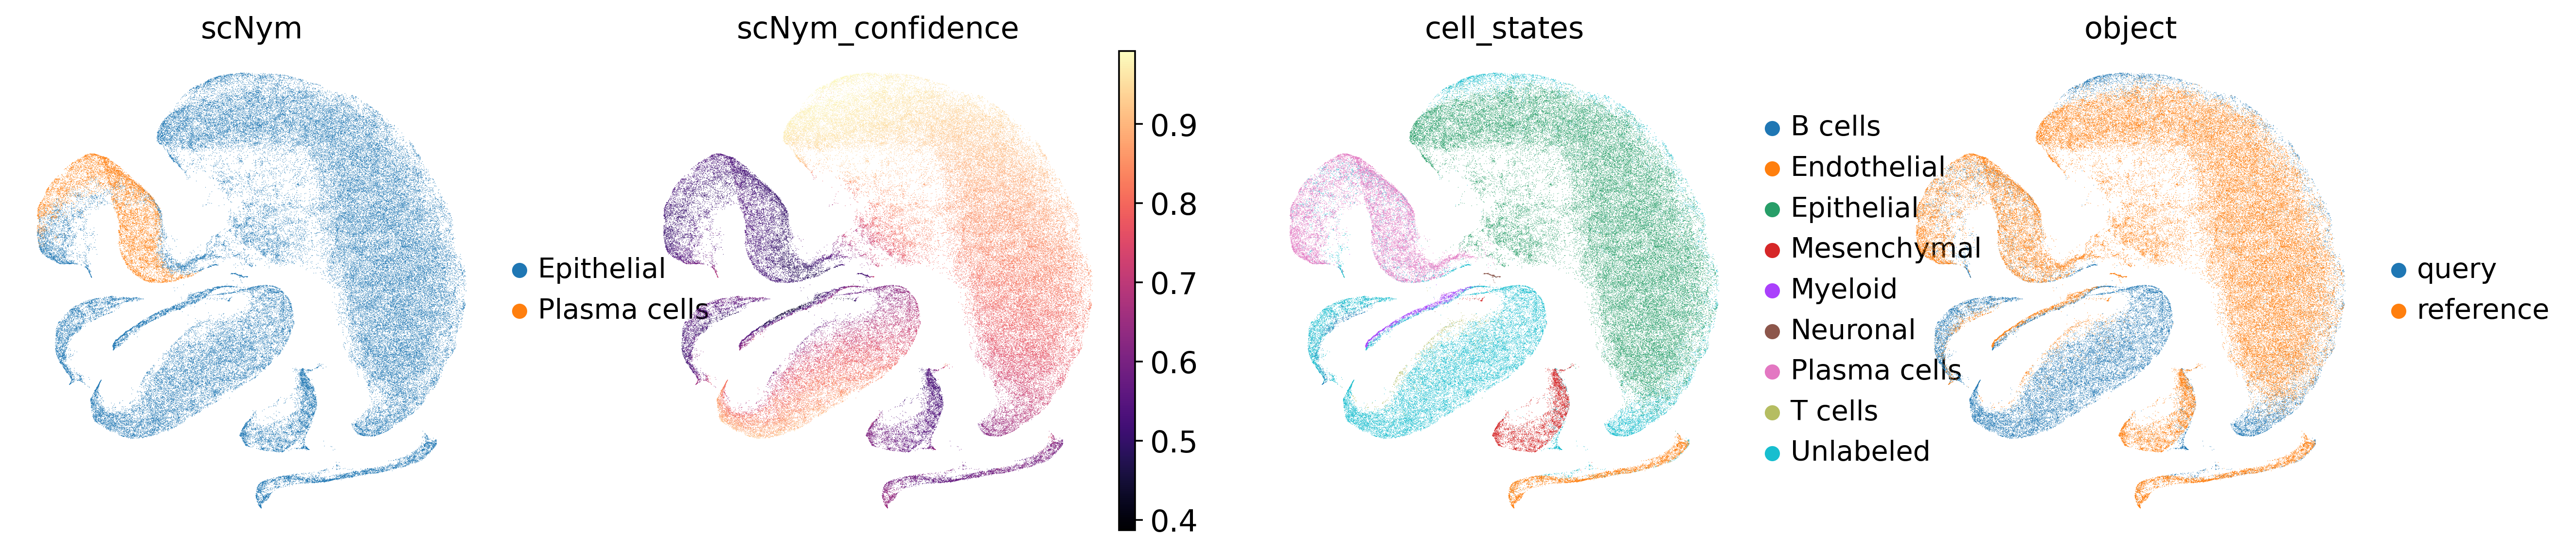

In [46]:
sc.pl.umap(REF_QUERY, color=['scNym', 'scNym_confidence','cell_states', 'object'], color_map = "magma", size = 0.3, frameon = False)